<a href="https://colab.research.google.com/github/scottspurlock/noisy_labels/blob/main/classification_noisy_labels.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Classification with noisy labels
## Scott Spurlock
### Created: 12-17-2020


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import os 
root_dir = "/content/drive/My Drive/Research/deepfakes/"
os.chdir(root_dir)

!pwd

/content/drive/My Drive/Research/deepfakes


In [4]:
!ls

classification_noisy_labels.ipynb  model2.png  papers  saved_model  scratch.py


### Define the number of "exemplars"
Or, the number of nodes in the penultimate layer of the network. The goal is that these operate as individual local detectors.

In [5]:
num_exemplars = 10

### Load the data

In [6]:
num_classes = 10
input_shape = (28, 28, 1)

# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

# Shuffle
# from sklearn.utils import shuffle
# x_train, y_train = shuffle(x_train, y_train, random_state=0)
# print(x_train.shape)
# rp = np.random.permutation(len(x_train))


## Keep only two classes for binary classification

In [7]:
# Only keep 2 classes
mask1 = y_train != 1
mask2 = y_train == 1
mask = mask1 | mask2
y_train[mask1] = 0
y_train[mask2] = 1
y_train = y_train[mask]
x_train = x_train[mask]

mask1 = y_test != 1
mask2 = y_test == 1
mask = mask1 | mask2
y_test[mask1] = 0
y_test[mask2] = 1
y_test = y_test[mask]
x_test = x_test[mask]

u = np.unique(y_train)
num_classes = len(u)


In [8]:
y_train.shape

(60000,)

In [9]:

# Scale images to the [0, 1] range
x_train = x_train.astype("float32") / 255
x_test = x_test.astype("float32") / 255
# Make sure images have shape (28, 28, 1)
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)
print("x_train shape:", x_train.shape)
print(x_train.shape[0], "train samples")
print(x_test.shape[0], "test samples")



x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples


In [10]:
# Subsample data
keep_frac = 1
n = int(len(x_train) * keep_frac)
x_train = x_train[:n]
y_train = y_train[:n]

print(y_train.shape)
print(x_train.shape)

(60000,)
(60000, 28, 28, 1)


## Change labels
Change a fraction of the labels from class 0 to class 1.

In [11]:
# Corrupt labels
change_frac = 0.5
# m = int(n * change_frac)
# rp = np.random.permutation(n)[:m]
# new_labels = np.random.randint(0, num_classes, m)
# y_train[rp] = new_labels
# print(y_train.shape)

# Randomly switch some negative examples to be positive
for i in range(len(y_train)):
  if (y_train[i] == 0 and np.random.random() < change_frac):
    y_train[i] = 1


In [12]:
# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

print(x_train.shape)
print(y_train.shape)


(60000, 28, 28, 1)
(60000, 2)


## Baseline model

In [13]:
model = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(),
        # layers.Dropout(0.5),
        layers.Dense(num_exemplars, activation="sigmoid"),
        layers.Dense(num_classes, activation="softmax"),
    ]
)

model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 1600)              0         
_________________________________________________________________
dense (Dense)                (None, 10)                16010     
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 2

## TODO: keep a validation set that isn't corrupted.

In [14]:
batch_size = 128
epochs = 5

model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

hist = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.1)


Epoch 1/5
422/422 [==============================] - 5s 6ms/step - loss: 0.6636 - accuracy: 0.5449 - val_loss: 0.6357 - val_accuracy: 0.5613
Epoch 2/5
422/422 [==============================] - 2s 5ms/step - loss: 0.6280 - accuracy: 0.5555 - val_loss: 0.6266 - val_accuracy: 0.5462
Epoch 3/5
422/422 [==============================] - 2s 4ms/step - loss: 0.6197 - accuracy: 0.5619 - val_loss: 0.6240 - val_accuracy: 0.5477
Epoch 4/5
422/422 [==============================] - 2s 5ms/step - loss: 0.6194 - accuracy: 0.5591 - val_loss: 0.6233 - val_accuracy: 0.5555
Epoch 5/5
422/422 [==============================] - 2s 5ms/step - loss: 0.6171 - accuracy: 0.5620 - val_loss: 0.6224 - val_accuracy: 0.5540


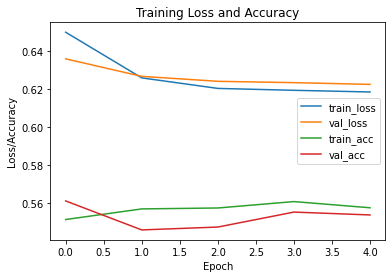

In [15]:
plt.figure()
plt.plot(hist.history["loss"], label="train_loss")
plt.plot(hist.history["val_loss"], label="val_loss")
plt.plot(hist.history["accuracy"], label="train_acc")
plt.plot(hist.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.show()


In [16]:
score = model.evaluate(x_test, y_test, verbose=1)
print("Test loss:", score[0])
print("Test accuracy:", score[1])


313/313 [==============================] - 1s 2ms/step - loss: 0.6155 - accuracy: 0.9119
Test loss: 0.615462601184845
Test accuracy: 0.911899983882904


In [17]:
# Adapted from: https://medium.com/@dtuk81/confusion-matrix-visualization-fc31e3f30fea
def show_cm(cf_matrix):
  group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
  group_counts = ["{0:0.0f}".format(value) for value in
                  cf_matrix.flatten()]
  group_percentages = ["{0:.2%}".format(value) for value in
                      cf_matrix.flatten()/np.sum(cf_matrix)]
  labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
            zip(group_names,group_counts,group_percentages)]
  labels = np.asarray(labels).reshape(2,2)
  sns.heatmap(cf_matrix, annot=labels, fmt='')
  plt.xlabel('Predicted')
  plt.ylabel('Actual')


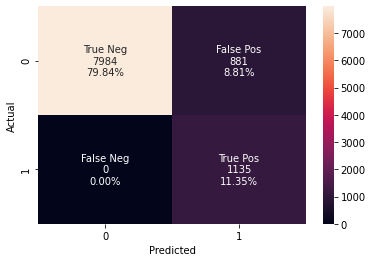

In [18]:
preds = model.predict(x_test, verbose=0)

# Generate arg maxes for predictions
y_pred = np.argmax(preds, axis=1)
y_true = np.argmax(y_test, axis=1)
cm = confusion_matrix(y_true, y_pred)
show_cm(cm)


In [19]:
idx = 0
model.predict(x_test[idx:idx+1], verbose=1)


1/1 [==============================] - 0s 30ms/step


array([[0.5047475 , 0.49525252]], dtype=float32)

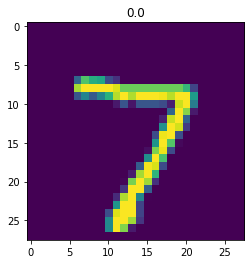

In [20]:
plt.figure()
plt.title(y_test[idx][1])
plt.imshow(np.squeeze(x_test[idx]))
plt.show()

# Exemplar Model
Create a layer with M nodes with the goal that each node is a "detector" that activates in a local region. We want:
- no detectors to fire (predict 1) when the true label is 0
- exactly one detector to fire when the true label is 1 (may be noisy)

The first goal can be met by comparing summed prediction across the outputs to 0.

The second goal can be met by either
- taking the L1 norm across the predictions to encourage sparsity
- taking the loss only on the highest valued output

# TODO: Figure out how to get predictions out of the model
One option is to add a trainable final layer that learns to predict based on the penultimate layer. This would require having two outputs and two losses.

Another option is to add a non-trainable final layer that just checks if the max exemplar output is above a threshold. Probably this is a custom layer?


In [21]:
# model = keras.Sequential(
#     [
#         keras.Input(shape=input_shape),
#         layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
#         layers.MaxPooling2D(pool_size=(2, 2)),
#         layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
#         layers.MaxPooling2D(pool_size=(2, 2)),
#         layers.Flatten(),
#         layers.Dropout(0.5),
#         layers.Dense(num_exemplars, activation="sigmoid")
#     ]
# )

# Switch to functional style so we can access intermediate layers more easily
inp = keras.Input(shape=input_shape, name='inp')
conv_1 = layers.Conv2D(32, kernel_size=(3, 3), activation="relu", name='conv_1')(inp)
pool_1 = layers.MaxPooling2D(pool_size=(2, 2), name='pool_1')(conv_1)
conv_2 = layers.Conv2D(64, kernel_size=(3, 3), activation="relu", name='conv_2')(pool_1)
pool_2 = layers.MaxPooling2D(pool_size=(2, 2), name='pool_2')(conv_2)
flat_1 = layers.Flatten(name='flat_1')(pool_2)
# do_1 = layers.Dropout(0.5, name='do_1')(flat_1)
fc_1 = layers.Dense(num_exemplars, activation='sigmoid', name='fc_1')(flat_1)
outp = layers.Dense(num_classes, activation="softmax", name='outp')(fc_1)

model = tf.keras.Model(inputs=inp, outputs=[outp, fc_1])

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inp (InputLayer)             [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv_1 (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
pool_1 (MaxPooling2D)        (None, 13, 13, 32)        0         
_________________________________________________________________
conv_2 (Conv2D)              (None, 11, 11, 64)        18496     
_________________________________________________________________
pool_2 (MaxPooling2D)        (None, 5, 5, 64)          0         
_________________________________________________________________
flat_1 (Flatten)             (None, 1600)              0         
_________________________________________________________________
fc_1 (Dense)                 (None, 10)                16010 

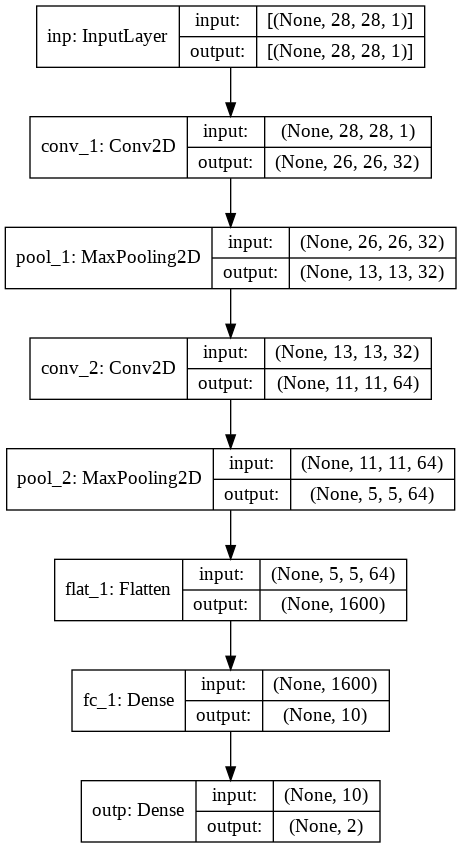

In [22]:
keras.utils.plot_model(model, 'model2.png', show_shapes=True)

## Define a custom loss class


In [23]:
class CustomExemplarLoss(keras.losses.Loss):
    def __init__(self, opt=1, name="custom_exemplar_loss"):
        super().__init__(name=name)
        self.opt = opt # Just a placeholder at the moment

    def call(self, y_true, y_pred):
        alpha_0 = 1.0
        alpha_1 = 0
        alpha_2 = 0

        # Find the difference of each prediction from gt
        # with any luck, tf will auto expand y_true
        diff = tf.abs(y_true - y_pred)
        # print('diff:', diff.shape)

        # Find the min difference along the last axis (columns)
        loss = tf.math.reduce_min(diff, axis=-1)
        # print('loss:', loss.shape)

        # Encourage sparsity:
        #   when true is 0, preds are all 0
        #   when true is 1, one pred is 1
        loss_s = tf.math.reduce_sum(diff, axis=-1)

        reg = tf.math.reduce_sum(tf.square(0 - y_pred), axis=-1)

        return alpha_0 * loss \
             + alpha_1 * loss_s \
             + alpha_2 * reg


In [24]:
print(model.outputs, '\n')

losses = {
    'outp': 'categorical_crossentropy',
    'fc_1': CustomExemplarLoss()
}

wts = {
    'outp': 1.0, 
    'fc_1': 1.0
}

opt = keras.optimizers.Adam()
model.compile(optimizer=opt, loss=losses, loss_weights=wts, metrics=["accuracy"])

batch_size = 128
epochs = 10

model.fit(x_train, [y_train, y_train[:,1]], batch_size=batch_size, epochs=epochs, validation_split=0.1)


[<KerasTensor: shape=(None, 2) dtype=float32 (created by layer 'outp')>, <KerasTensor: shape=(None, 10) dtype=float32 (created by layer 'fc_1')>] 

Epoch 1/10
422/422 [==============================] - 4s 7ms/step - loss: 0.6915 - outp_loss: 0.6593 - fc_1_loss: 0.0322 - outp_accuracy: 0.5481 - fc_1_accuracy: 0.0456 - val_loss: 0.6337 - val_outp_loss: 0.6337 - val_fc_1_loss: 1.6524e-07 - val_outp_accuracy: 0.5552 - val_fc_1_accuracy: 0.1660
Epoch 2/10
422/422 [==============================] - 2s 6ms/step - loss: 0.6233 - outp_loss: 0.6233 - fc_1_loss: 2.5872e-07 - outp_accuracy: 0.5575 - fc_1_accuracy: 0.1442 - val_loss: 0.6272 - val_outp_loss: 0.6272 - val_fc_1_loss: 7.6569e-07 - val_outp_accuracy: 0.5552 - val_fc_1_accuracy: 0.0653
Epoch 3/10
422/422 [==============================] - 2s 6ms/step - loss: 0.6207 - outp_loss: 0.6207 - fc_1_loss: 1.2037e-06 - outp_accuracy: 0.5574 - fc_1_accuracy: 0.0672 - val_loss: 0.6236 - val_outp_loss: 0.6236 - val_fc_1_loss: 1.5626e-07 - val_outp_a

## Testing
The model outputs the y predictions (one-hot) as well as the penultimate layer outputs ("detectors").

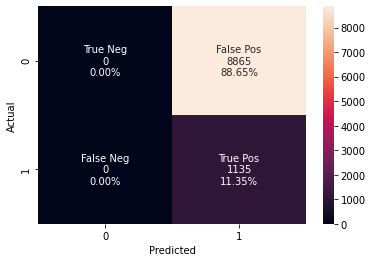

Accuracy = 11.35%

--------

Preds based on detector output
Accuracy = 11.35%


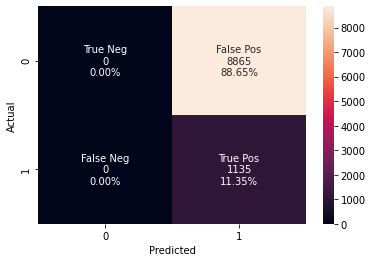

In [25]:
y_pred, detectors = model.predict(x_test, verbose=0)

# Undo one-hot encoding
y_pred = np.argmax(y_pred, axis=1)

preds = np.max(detectors, axis=1)
preds = np.where(preds < 0.5, 0, 1)

# Generate arg maxes for predictions
y_true = np.argmax(y_test, axis=1)
cm = confusion_matrix(y_true, y_pred)
show_cm(cm)
plt.show()
print('Accuracy = {:.2f}%'.format(100*np.sum(np.diag(cm))/np.sum(cm)))

print('\n--------\n')
print('Preds based on detector output')
cm = confusion_matrix(y_true, preds)
show_cm(cm)
print('Accuracy = {:.2f}%'.format(100*np.sum(np.diag(cm))/np.sum(cm)))


## Show some results
Ideally, outputs are all close to zero when true label is 0, and one output is close to 1 when true label is 1.


In [26]:
y_pred, detectors = model.predict(x_test[0:1], verbose=0)
detectors

array([[9.9999583e-01, 3.9833065e-08, 7.8105001e-07, 9.9997807e-01,
        1.0000000e+00, 9.9999607e-01, 1.2418729e-09, 4.2715239e-08,
        6.0778724e-08, 1.3388648e-08]], dtype=float32)

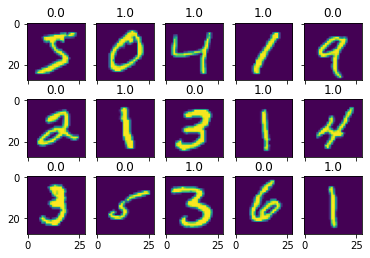

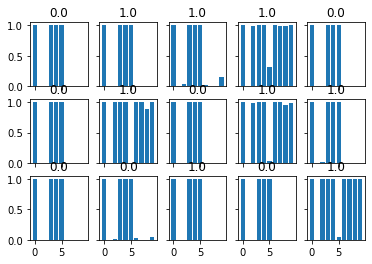

In [27]:
num_rows = 3
num_cols = 5

use_train = True

if use_train:
  y_split = y_train
  x_split = x_train
else:
  y_split = y_test
  x_split = x_test

fig, ax = plt.subplots(num_rows, num_cols, sharex='col', sharey='row')
for i in range(num_rows):
    for j in range(num_cols):
        idx = i*num_cols + j
        ax[i, j].set_title(y_split[idx][1])
        ax[i, j].imshow(np.squeeze(x_split[idx]))

fig, ax = plt.subplots(num_rows, num_cols, sharex='col', sharey='row')
for i in range(num_rows):
    for j in range(num_cols):
        idx = i*num_cols + j
        ax[i, j].set_title(y_split[idx][1])
        # run example through the model to get predictions
        y_pred, preds = model.predict(x_split[idx:idx+1])
        y_pred = y_pred[0]
        preds = preds[0]
        # print(i, j, y_pred)
        # print(i, j, preds)
        bins = np.arange(len(preds))
        ax[i, j].bar(bins, preds)

plt.show()




## Save/load models

In [28]:
from tensorflow.keras.models import save_model, load_model
# Save the model
filepath = './saved_model'
save_model(model, filepath)

INFO:tensorflow:Assets written to: ./saved_model/assets


In [29]:
# Load the model
#model = load_model(filepath, compile = True)
